In [41]:
import requests
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.PDB import PDBParser
import py3Dmol
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis

# Defining Functions

In [2]:
# Combined function to get protein data and export files
def fetch_protein_data(uniprot_id, output_dirs):
    # Set up API endpoints
    api_url = f"https://alphafold.ebi.ac.uk/api/prediction/{uniprot_id}"
    uniprot_url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json?fields=ft_topo_dom%2Cft_transmem"
    
    try:
        # Get protein details
        response = requests.get(api_url, timeout=10)
        response.raise_for_status()
        protein_data = response.json()[0]
        
        # Export PDB file
        pdb_url = protein_data.get('pdbUrl')
        if pdb_url:
            pdb_response = requests.get(pdb_url)
            with open(os.path.join(output_dirs['pdb'], f"{uniprot_id}.pdb"), 'wb') as pdb_file:
                pdb_file.write(pdb_response.content)
        
        # Export image file
        image_url = protein_data.get('paeImageUrl')
        if image_url:
            image_response = requests.get(image_url)
            with open(os.path.join(output_dirs['images'], f"{uniprot_id}_image.png"), 'wb') as image_file:
                image_file.write(image_response.content)

        # Save protein data as a text file
        with open(os.path.join(output_dirs['text'], f"{uniprot_id}_details.txt"), 'w') as text_file:
            json.dump(protein_data, text_file, indent=2)
        
        return protein_data
    except requests.RequestException as e:
        print(f"Error fetching data for {uniprot_id}: {e}")
        return None

In [3]:
# Extract helical details for each protein
def extract_helical_regions(uniprot_id):
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json?fields=ft_topo_dom%2Cft_transmem"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error fetching data for {uniprot_id}")
        return None

    data = response.json()
    tm_regions = []
    for feature in data.get('features', []):
        if feature.get('type') == 'Transmembrane' and 'Helical' in feature.get('description', ''):
            start = feature['location']['start']['value']
            end = feature['location']['end']['value']
            tm_regions.append((start, end))
    return tm_regions

In [4]:
# Generate a dataframe with start and end positions of TMHs
def create_helical_df(uniprot_ids):
    data = []
    for uniprot_id in uniprot_ids:
        tm_regions = extract_helical_regions(uniprot_id)
        if tm_regions is not None:
            row = [uniprot_id] + [coord for region in tm_regions for coord in region]
            data.append(row + [None] * (15 - len(row)))  # Pad to maintain consistent column count
        print(f"Successfully extracted helical details for {uniprot_id}")
    column_names = ['protein'] + [f'TMH {i+1} Start' for i in range(7)] + [f'TMH {i+1} End' for i in range(7)]
    return pd.DataFrame(data, columns=column_names)

In [5]:
# Parse C-alpha coordinates and create final dataframe
def parse_coordinates(pdb_file, tmh_positions):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    coords = {f'TMH {i+1}': [] for i in range(7)}

    for tmh_idx, (start, end) in enumerate(tmh_positions):
        atoms = []
        for model in structure:
            for chain in model:
                for residue in chain.get_residues():
                    if start <= residue.id[1] <= end and "CA" in residue:
                        atom = residue["CA"]
                        atoms.extend(atom.coord)
        coords[f'TMH {tmh_idx+1}'] = atoms

    # Flatten coordinates into dataframe format
    data = {'protein': pdb_file}
    for tmh, atom_coords in coords.items():
        for idx, coord in enumerate(atom_coords):
            data[f'{tmh} Atom {idx // 3 + 1} {["X", "Y", "Z"][idx % 3]}'] = coord
    return pd.DataFrame([data])

In [ ]:
# # 3D visualization
# def visualize_proteins(uniprot_ids, output_dirs):
#     os.makedirs(output_dirs['pdb'], exist_ok=True)
#     os.makedirs(output_dirs['images'], exist_ok=True)
#     os.makedirs(output_dirs['text'], exist_ok=True)

#     for uniprot_id in uniprot_ids:
#         protein_data = fetch_protein_data(uniprot_id, output_dirs)
        
#         if protein_data:
#             # Show 3D visualization
#             pdb_url = protein_data.get('pdbUrl')
#             if pdb_url:
#                 pdb_data = requests.get(pdb_url).text
#                 view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
#                 view.addModel(pdb_data, 'pdb')
#                 view.setStyle({'cartoon': {'color': 'spectrum'}})
#                 view.zoomTo()
#                 display(view)

In [6]:
# 3D visualization
def visualize_proteins(uniprot_ids, output_dirs):
    os.makedirs(output_dirs['pdb'], exist_ok=True)

    for uniprot_id in uniprot_ids:
        pdb_file_path = os.path.join('PDB_Files', f"{uniprot_id}.pdb")
        
        if os.path.exists(pdb_file_path):
            with open(pdb_file_path, 'r') as pdb_file:
                pdb_data = pdb_file.read()
            
            # Show 3D visualization
            view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
            view.addModel(pdb_data, 'pdb')
            view.setStyle({'cartoon': {'color': 'spectrum'}})
            view.zoomTo()
            display(view)
        else:
            print(f"PDB file for {uniprot_id} not found in PDB_Files folder.")


In [7]:
# Final dataframe
def process_proteins(uniprot_ids, output_dirs):
    os.makedirs(output_dirs['pdb'], exist_ok=True)
    os.makedirs(output_dirs['images'], exist_ok=True)
    os.makedirs(output_dirs['text'], exist_ok=True)
    
    # Final dataframe for all proteins
    final_coord_dfs = []
    for uniprot_id in uniprot_ids:
        protein_data = fetch_protein_data(uniprot_id, output_dirs)
        
        if protein_data:
            # Extract and parse TMH coordinates
            tmh_positions = extract_helical_regions(uniprot_id)
            if tmh_positions:
                pdb_file = os.path.join(output_dirs['pdb'], f"{uniprot_id}.pdb")
                coord_df = parse_coordinates(pdb_file, tmh_positions)
                final_coord_dfs.append(coord_df)
        print(f"Successfully processed {uniprot_id}!")
    
    final_coord_df = pd.concat(final_coord_dfs, ignore_index=True)
    final_coord_df['protein'] = final_coord_df['protein'].str.extract(r'([^/]+)\.pdb$')[0]
    
    # Combine all parsed coordinates into a single dataframe
    return final_coord_df

# Data Extraction

In [8]:
file_path = 'GPCRTargets.csv'
gpcr_targets_df = pd.read_csv(file_path, header=1)
gpcr_targets_df.head()

,Type,Family id,Family name,Target id,Target name,Subunits,Target systematic name,Target abbreviated name,synonyms,HGNC id,...,Rat SwissProt,Rat Entrez Gene,MGI id,MGI symbol,MGI name,Mouse genetic localisation,Mouse nucleotide RefSeq,Mouse protein RefSeq,Mouse SwissProt,Mouse Entrez Gene
0,gpcr,16,Class A Orphans,83,<i>GPR3</i>,NaN,NaN,NaN,Gpcr21|GPCR3|ACCA orphan receptor|adenylate cy...,4484.0,...,Q8K1Q3,266769,MGI:101908,Gpr3,G-protein coupled receptor 3,4 D2.3,NM_008154,NP_032180,P35413,14748
1,gpcr,16,Class A Orphans,84,<i>GPR4</i>,NaN,NaN,NaN,GPR19|G-protein coupled receptor 19,4497.0,...,Q4KLH9,308408,MGI:2441992,Gpr4,G protein-coupled receptor 4,7 A3,NM_175668,NP_783599,Q8BUD0,319197
2,gpcr,16,Class A Orphans,228,<i>GPR42</i>,NaN,NaN,NaN,FFAR1L|GPR41L|FFAR3L|G protein-coupled recepto...,4500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,gpcr,16,Class A Orphans,85,<i>GPR6</i>,NaN,NaN,NaN,Sphingosine 1-phosphate receptor GPR6,4515.0,...,P51651,83683,MGI:2155249,Gpr6,G protein-coupled receptor 6,10 22.08 cM,NM_199058,NP_951013,Q6YNI2,140741
4,gpcr,16,Class A Orphans,86,<i>GPR12</i>,NaN,NaN,NaN,Gpcr01|Gpcr20|GPCR21|GPCR12|R334,4466.0,...,P30951,80840,MGI:101909,Gpr12,G-protein coupled receptor 12,5 G3,NM_008151,NP_032177,P35412,14738


In [9]:
uniprot_ids = gpcr_targets_df['Human SwissProt'].dropna().tolist()
uniprot_ids

['P46089',
 'P46093',
 'O15529',
 'P46095',
 'P47775',
 'P49685',
 'Q13304',
 'Q15760',
 'Q99678',
 'Q99679',
 'Q99680',
 'O00155',
 'Q8NDV2',
 'Q9NS67',
 'O00270',
 'O75388',
 'Q49SQ1',
 'Q9UPC5',
 'Q9HC97',
 'O15354',
 'O60883',
 'O43194',
 'Q9Y5Y3',
 'Q13585',
 'Q9Y2T5',
 'Q9BZJ8',
 'Q9BZJ7',
 'Q9BZJ6',
 'Q8IYL9',
 'Q15743',
 'O95800',
 'Q96P69',
 'Q96P67',
 'Q9NYM4',
 'Q9NQS5',
 'P60893',
 'Q9BY21',
 'Q9GZN0',
 'Q96P66',
 'Q9UNW8',
 'Q8IZ08',
 'Q6DWJ6',
 'Q7Z602',
 'Q7Z601',
 'Q96CH1',
 'Q8TDV2',
 'Q86SP6',
 'Q8NGU9',
 'Q8TDV0',
 'Q8TDT2',
 'Q6NV75',
 'Q9UJ42',
 'Q8N6U8',
 'Q16538',
 'O14626',
 'Q9NS66',
 'Q9BXC1',
 'Q14439',
 'O15218',
 'P32249',
 'Q9BXB1',
 'O75473',
 'Q9HBX8',
 'P04201',
 'P35410',
 'Q8TDS7',
 'Q86SM8',
 'Q96AM1',
 'Q86SM5',
 'Q96LB2',
 'Q96LB1',
 'Q96LB0',
 'Q96LA9',
 'Q86VZ1',
 'O00398',
 'Q9P1P5',
 'Q9P1P4',
 'O14804',
 'Q96RI8',
 'Q969N4',
 'Q96RI9',
 'Q8NFN8',
 'Q5T848',
 'Q6PRD1',
 'Q8NFJ5',
 'Q9NZH0',
 'Q9NQ84',
 'Q9NZD1',
 'Q5T6X5',
 'P04000',
 'P04001',

In [10]:
# Define output directories for files
output_dirs = {
    'pdb': 'PDB_Files',
    'images': 'Images',
    'text': 'Text_Files'
}

# Generate TMH dataframe
tmh_df = create_helical_df(uniprot_ids)

Successfully extracted helical details for P46089
Successfully extracted helical details for P46093
Successfully extracted helical details for O15529
Successfully extracted helical details for P46095
Successfully extracted helical details for P47775
Successfully extracted helical details for P49685
Successfully extracted helical details for Q13304
Successfully extracted helical details for Q15760
Successfully extracted helical details for Q99678
Successfully extracted helical details for Q99679
Successfully extracted helical details for Q99680
Successfully extracted helical details for O00155
Successfully extracted helical details for Q8NDV2
Successfully extracted helical details for Q9NS67
Successfully extracted helical details for O00270
Successfully extracted helical details for O75388
Successfully extracted helical details for Q49SQ1
Successfully extracted helical details for Q9UPC5
Successfully extracted helical details for Q9HC97
Successfully extracted helical details for O15354


In [11]:
tmh_df

,protein,TMH 1 Start,TMH 2 Start,TMH 3 Start,TMH 4 Start,TMH 5 Start,TMH 6 Start,TMH 7 Start,TMH 1 End,TMH 2 End,TMH 3 End,TMH 4 End,TMH 5 End,TMH 6 End,TMH 7 End
0,P46089,43,62,75,98,111,132,154,173,199,217,246.0,272.0,278.0,299.0
1,P46093,18,42,55,76,92,113,133,154,180,201,225.0,245.0,264.0,284.0
2,O15529,20,40,48,68,91,111,133,153,179,199,223.0,243.0,259.0,279.0
3,P46095,75,94,107,130,143,164,186,205,231,249,278.0,304.0,310.0,331.0
4,P47775,49,69,78,98,114,134,159,179,200,220,253.0,273.0,283.0,303.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,P30518,39,63,78,98,114,135,160,180,201,220,272.0,293.0,309.0,328.0
396,P30559,39,63,75,97,114,135,155,175,203,225,276.0,294.0,310.0,332.0
397,P41586,156,178,187,205,228,253,269,291,310,332,351.0,371.0,386.0,405.0
398,P32241,143,167,175,194,217,240,255,276,293,316,342.0,361.0,374.0,393.0


In [12]:
# Generate final parsed coordinates dataframe
final_coord_df = process_proteins(uniprot_ids, output_dirs)

Successfully processed P46089!
Successfully processed P46093!
Successfully processed O15529!
Successfully processed P46095!
Successfully processed P47775!
Successfully processed P49685!
Successfully processed Q13304!
Successfully processed Q15760!
Successfully processed Q99678!
Successfully processed Q99679!
Successfully processed Q99680!
Successfully processed O00155!
Successfully processed Q8NDV2!
Successfully processed Q9NS67!
Successfully processed O00270!
Successfully processed O75388!
Successfully processed Q49SQ1!
Successfully processed Q9UPC5!
Successfully processed Q9HC97!
Successfully processed O15354!
Successfully processed O60883!
Successfully processed O43194!
Successfully processed Q9Y5Y3!
Successfully processed Q13585!
Successfully processed Q9Y2T5!
Successfully processed Q9BZJ8!
Successfully processed Q9BZJ7!
Successfully processed Q9BZJ6!
Successfully processed Q8IYL9!
Successfully processed Q15743!
Successfully processed O95800!
Successfully processed Q96P69!
Successf

In [13]:
final_coord_df

,protein,TMH 1 Atom 1 X,TMH 1 Atom 1 Y,TMH 1 Atom 1 Z,TMH 1 Atom 2 X,TMH 1 Atom 2 Y,TMH 1 Atom 2 Z,TMH 1 Atom 3 X,TMH 1 Atom 3 Y,TMH 1 Atom 3 Z,...,TMH 6 Atom 37 Z,TMH 6 Atom 38 X,TMH 6 Atom 38 Y,TMH 6 Atom 38 Z,TMH 6 Atom 39 X,TMH 6 Atom 39 Y,TMH 6 Atom 39 Z,TMH 6 Atom 40 X,TMH 6 Atom 40 Y,TMH 6 Atom 40 Z
0,P46089,18.181000,9.848,2.520,18.709,6.383,0.899000,20.353001,5.215,4.158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P46093,16.534000,8.483,-2.642,12.923,9.488,-1.816000,10.896000,6.470,-3.201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,O15529,-4.308000,8.137,-11.168,-2.104,10.098,-8.703000,-4.585000,13.022,-8.735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P46095,16.537001,10.738,-0.570,17.379,7.001,-0.938000,19.110001,7.116,2.495,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P47775,18.605000,-7.709,-5.014,17.539,-6.518,-1.502000,14.363000,-4.891,-2.952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,P30518,-1.123000,-11.384,-22.521,-0.009,-8.411,-20.327999,-1.925000,-5.950,-22.576,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391,P30559,18.979000,17.716,-1.864,20.632,18.118,1.610000,17.183001,18.646,3.202,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
392,P41586,-14.070000,-0.128,-14.074,-11.946,1.544,-11.334000,-12.740000,5.087,-12.670,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
393,P32241,-6.532000,-4.218,-12.903,-9.990,-5.224,-14.145000,-10.675000,-7.064,-10.840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Visualize each protein
# visualize_proteins(uniprot_ids, output_dirs)

# Data Preprocessing

In [23]:
# Drop columns with more than 50% NA values
threshold = len(final_coord_df) * 0.5
df_cleaned = final_coord_df.dropna(axis=1, thresh=threshold)

# Handle missing numeric values
df_cleaned.iloc[:, 1:] = df_cleaned.iloc[:, 1:].fillna(df_cleaned.iloc[:, 1:].mean())

# Standardize
df_scaled = StandardScaler().fit_transform(df_cleaned.iloc[:, 1:])
df_scaled = pd.DataFrame(df_scaled, columns=df_cleaned.columns[1:])
df_scaled

,TMH 1 Atom 1 X,TMH 1 Atom 1 Y,TMH 1 Atom 1 Z,TMH 1 Atom 2 X,TMH 1 Atom 2 Y,TMH 1 Atom 2 Z,TMH 1 Atom 3 X,TMH 1 Atom 3 Y,TMH 1 Atom 3 Z,TMH 1 Atom 4 X,...,TMH 1 Atom 21 Z,TMH 4 Atom 21 X,TMH 4 Atom 21 Y,TMH 4 Atom 21 Z,TMH 5 Atom 20 X,TMH 5 Atom 20 Y,TMH 5 Atom 20 Z,TMH 5 Atom 21 X,TMH 5 Atom 21 Y,TMH 5 Atom 21 Z
0,1.081149,0.608960,0.451045,1.158123,0.372812,0.333504,1.287727,0.298273,0.505472,1.122320,...,-2.868145e-08,2.057950e-08,-4.306699e-09,-8.797024e-09,-9.655074e-09,4.771441e-09,7.065780e-09,3.212376e-09,-7.154634e-09,1.080098e-08
1,0.980743,0.505243,0.146315,0.803285,0.618525,0.168424,0.702032,0.400986,0.049565,0.857724,...,3.354931e-01,-2.492874e-01,-7.962530e-01,-9.265879e-01,-6.565141e-01,1.139236e+00,-3.746847e-01,-6.137697e-01,8.926072e-01,-2.425526e-01
2,-0.289853,0.478953,-0.357002,-0.118275,0.666798,-0.250327,-0.256745,0.937223,-0.293279,-0.424030,...,6.694252e-01,1.216990e+00,1.874627e-01,-7.247745e-02,4.874711e-01,-1.220248e+00,-1.531684e-01,4.698665e-01,-1.102819e+00,2.416874e-02
3,0.980926,0.676585,0.268632,1.076558,0.421717,0.221809,1.210745,0.453857,0.402445,1.026581,...,-2.868145e-08,2.057950e-08,-4.306699e-09,-8.797024e-09,-9.655074e-09,4.771441e-09,7.065780e-09,3.212376e-09,-7.154634e-09,1.080098e-08
4,1.106997,-0.725074,0.006288,1.086370,-0.648105,0.187516,0.916752,-0.528836,0.064991,0.880469,...,-8.812473e-02,2.840086e-02,9.826118e-01,-8.868161e-01,-8.680717e-02,1.182725e+00,5.746954e-01,-7.291230e-02,8.471314e-01,5.843343e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,-0.095685,-1.004312,-1.027207,0.010205,-0.797907,-0.957163,-0.092005,-0.615508,-1.150761,-0.273592,...,-7.205619e-01,5.054723e-01,1.134888e+00,-9.794901e-01,3.013867e-01,1.766784e-01,2.687591e-01,3.212376e-09,-7.154634e-09,1.080098e-08
391,1.129798,1.206794,0.192243,1.276054,1.301458,0.376735,1.091401,1.397510,0.446245,1.021389,...,7.604519e-01,6.762285e-01,-3.925549e-01,-6.407004e-01,-5.840424e-01,2.126303e-01,2.493016e-02,-4.708186e-01,2.341546e-01,1.911022e-01
392,-0.884976,-0.149047,-0.528553,-0.721855,-0.010121,-0.410300,-0.761804,0.287797,-0.537061,-0.979737,...,2.448016e-01,8.670972e-01,8.235821e-01,-1.262043e-01,-2.753569e-01,-1.211238e+00,6.033912e-01,-3.086525e-01,-9.806023e-01,7.107324e-01
393,-0.425435,-0.459817,-0.459425,-0.601900,-0.545704,-0.581218,-0.633914,-0.706681,-0.423689,-0.567608,...,-1.158965e-01,4.093339e-01,1.452047e+00,2.953007e-01,-2.584048e-02,-4.813713e-01,5.730277e-01,5.947031e-02,-7.235948e-01,6.655741e-01


# Principal Component Analysis

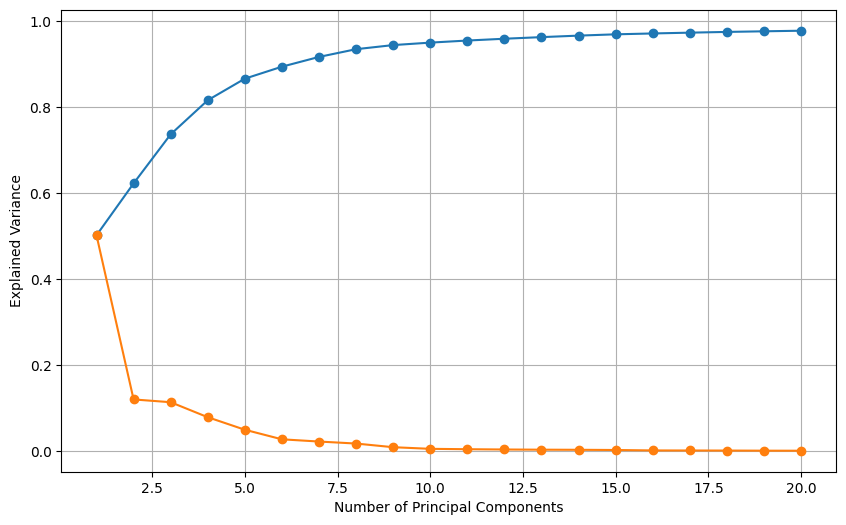

The best number of components that explain at least 90% of the variance: 7
Explained variance ratio for the best 7 components: [0.5020421  0.12053021 0.11407911 0.07923393 0.05011028 0.02785112
 0.02267975]


In [35]:
explained_variance_ratios = []
cumulative_variance = []

# Try different n_components from 1 to a max value, let's assume 10 as a reasonable upper bound
for n in range(1, 21):
    pca = PCA(n_components=n)
    pca.fit(df_scaled)
    explained_variance_ratios.append(pca.explained_variance_ratio_)
    cumulative_variance.append(np.cumsum(pca.explained_variance_ratio_))

# Convert lists to DataFrame for easy visualization
explained_variance_df = pd.DataFrame(explained_variance_ratios, columns=[f'PC{i+1}' for i in range(20)])
cumulative_variance_df = pd.DataFrame(cumulative_variance, columns=[f'PC{i+1}' for i in range(20)])

# Plot cumulative explained variance to visualize the best n_components
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 21), cumulative_variance_df.iloc[-1, :], marker='o', label='cumulative')
plt.plot(np.arange(1, 21), explained_variance_df.iloc[-1, :], marker='o', label='individual')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.show()

# Now, let's find the smallest n_components that explain at least 90% of the variance
for i, cum_variance in enumerate(cumulative_variance_df.iloc[-1, :]):
    if cum_variance >= 0.9:
        best_n_components = i + 1
        break

print(f"The best number of components that explain at least 90% of the variance: {best_n_components}")

# You can now perform PCA with the selected best n_components
pca = PCA(n_components=best_n_components)
pca_result = pca.fit_transform(df_scaled)
print(f"Explained variance ratio for the best {best_n_components} components: {pca.explained_variance_ratio_}")

In [53]:
cov = pca.get_params
cov

<bound method BaseEstimator.get_params of PCA(n_components=7)>

In [44]:
pca_df = pd.DataFrame(pca_result)
pca_df["target"] = final_coord_df.protein
pca_df

,0,1,2,3,4,5,6,target
0,-0.969915,-4.977006,-8.434291,5.241657,-1.946587,-0.069578,3.527622,P46089
1,-2.989424,-4.795770,-7.911372,7.748586,-1.205646,0.811125,-1.910188,P46093
2,-1.603084,8.865639,1.581896,-2.040349,-1.701863,-0.323966,3.289272,O15529
3,-1.574291,-3.044393,-9.395685,5.330021,-1.442224,-0.113387,2.531152,P46095
4,-2.862559,-10.629748,-0.232362,3.190720,-4.544010,-0.700682,2.992910,P47775
...,...,...,...,...,...,...,...,...
390,-2.999625,-0.552900,10.844832,-1.019225,-3.891328,-1.151346,-2.595760,P30518
391,-3.372493,0.476698,-10.266603,4.880255,-1.074445,0.294029,4.203469,P30559
392,2.651293,8.005539,7.969207,0.568216,-0.044645,-0.407066,-0.441369,P41586
393,3.956620,2.705624,11.306044,0.087898,-0.772746,-0.735815,0.568956,P32241


# Factor Analysis

Factor Analysis components for 7 factors:
[[ 0.6880937   0.33642317 -0.58308142 ...  0.74012359  0.29961134
  -0.86254825]
 [-0.03320436  0.73857256  0.11780308 ... -0.26504595 -0.44729435
  -0.16952424]
 [ 0.27926325 -0.2002183   0.50974539 ... -0.02725163  0.56640962
  -0.08747945]
 ...
 [ 0.39946121  0.04600268 -0.2878664  ... -0.00292458 -0.30910607
   0.36043395]
 [ 0.20745972 -0.26243706  0.04797858 ... -0.26820916 -0.28085059
  -0.10807406]
 [-0.24244855 -0.07699969 -0.3772294  ... -0.10130356  0.08121147
  -0.03454644]]


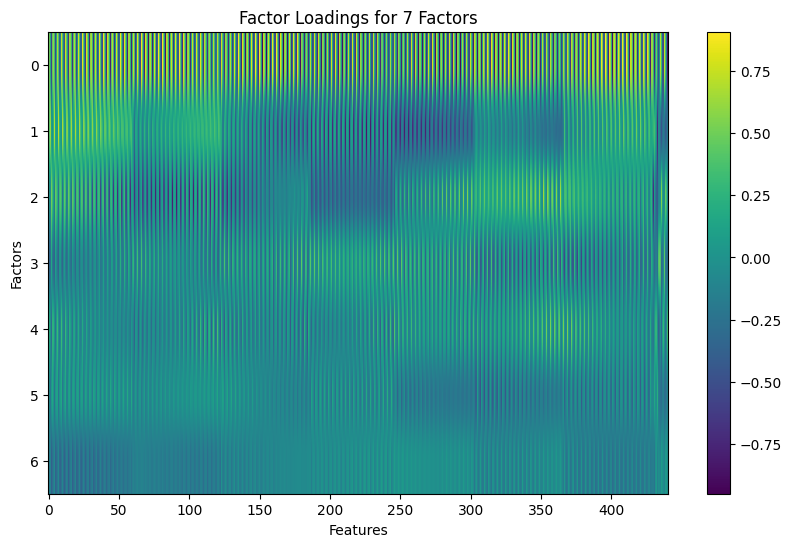

In [38]:
fa = FactorAnalysis(n_components=best_n_components)
fa_result = fa.fit_transform(df_scaled)
print(f"Factor Analysis components for {best_n_components} factors:")
print(fa.components_)

# Optionally, visualize the factor loadings
plt.figure(figsize=(10, 6))
plt.imshow(fa.components_, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title(f"Factor Loadings for {best_n_components} Factors")
plt.ylabel('Factors')
plt.xlabel('Features')
plt.show()

# Others

hello

In [ ]:
# Step 5: Hierarchical Clustering
linked = linkage(df_scaled, 'ward')
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

# Step 6: K-Means Clustering
kmeans = KMeans(n_clusters=3)  # You can adjust the number of clusters
kmeans_labels = kmeans.fit_predict(df_scaled)

# Step 7: DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can adjust these parameters
dbscan_labels = dbscan.fit_predict(df_scaled)

# Display clustering results
df_imputed['KMeans_Label'] = kmeans_labels
df_imputed['DBSCAN_Label'] = dbscan_labels

# Optionally, you can visualize the clusters from PCA results
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels)
plt.title('PCA - KMeans Clustering')
plt.show()